# **Exercise 3: Predict Cancer Mortality Rates in US Counties**

The provided dataset comprises data collected from multiple counties in the US. The regression task for this assessment is to predict cancer mortality rates in "unseen" US counties, given some training data.

The training data ('Training_data.csv') comprises various features/predictors related to socio-economic characteristics, amongst other types of information for specific counties in the country. The corresponding target variables for the training set are provided in a separate CSV file ('Training_data_targets.csv'). 


**Data Dictionary**

avgAnnCount: Mean number of reported cases of cancer diagnosed annually

avgDeathsPerYear: Mean number of reported mortalities due to cancer

incidenceRate: Mean per capita (100,000) cancer diagoses

medianIncome: Median income per county

popEst2015: Population of county

povertyPercent: Percent of populace in poverty

MedianAge: Median age of county residents

MedianAgeMale: Median age of male county residents

MedianAgeFemale: Median age of female county residents

AvgHouseholdSize: Mean household size of county

PercentMarried: Percent of county residents who are married

PctNoHS18_24: Percent of county residents ages 18-24 highest education attained: less than high school

PctHS18_24: Percent of county residents ages 18-24 highest education attained: high school diploma

PctSomeCol18_24: Percent of county residents ages 18-24 highest education attained: some college

PctBachDeg18_24: Percent of county residents ages 18-24 highest education attained: bachelor's degree

PctHS25_Over: Percent of county residents ages 25 and over highest education attained: high school diploma

PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor's degree

PctEmployed16_Over: Percent of county residents ages 16 and over employed

PctUnemployed16_Over: Percent of county residents ages 16 and over unemployed

PctPrivateCoverage: Percent of county residents with private health coverage

PctPrivateCoverageAlone: Percent of county residents with private health coverage alone (no public assistance)

PctEmpPrivCoverage: Percent of county residents with employee-provided private health coverage

PctPublicCoverage: Percent of county residents with government-provided health coverage

PctPubliceCoverageAlone: Percent of county residents with government-provided health coverage alone

PctWhite: Percent of county residents who identify as White

PctBlack: Percent of county residents who identify as Black

PctAsian: Percent of county residents who identify as Asian

PctOtherRace: Percent of county residents who identify in a category which is not White, Black, or Asian

PctMarriedHouseholds: Percent of married households

BirthRate: Number of live births relative to number of women in county

First, reading in the training data and targets files. The training data comprises of features/predictors while the targets file comprises the targets (i.e. cancer mortality rates in US counties) to train models to predict.

In [7]:
import os
import pandas as pd

## Define paths to the training data and targets files
training_data_path = 'Training_data.csv'
training_targets_path = 'Training_data_targets.csv'

Starting by importing essential visualization libraries, `matplotlib.pyplot` and `seaborn`. With these tools, I can load my training data and target variables from CSV files. This forms the basis of the dataset.

Once I have my data ready, I combine the features and targets into a single DataFrame. Handling data in this integrated manner is particularly useful for correlational analysis and visualization tasks.

Next, I focus on cleaning the data, particularly looking at the `MedianAge` feature. I identify and correct any outliers—values above 100 in this case—by replacing them with the mean age of the dataset. This normalization helps in mitigating any skew that these outliers might introduce into the predictive models. For a thorough exploratory analysis, histograms are plotted for each feature in the dataset. These histograms help visualize the distribution of data points, detect any skewness, and identify further outliers.

Then I examine the correlations between the features and the target variable, `TARGET_deathRate`. By sorting these correlations, I identify the top five features that have the strongest relationship with the target. This step ishelps informs me about the features that are most likely to influence the predictions in my model.

To visualise further, I plot a scatter matrix for the top five correlated features using Seaborn's `pairplot`. This matrix is particularly helpful for spotting trends, patterns, and potential interactions between features.

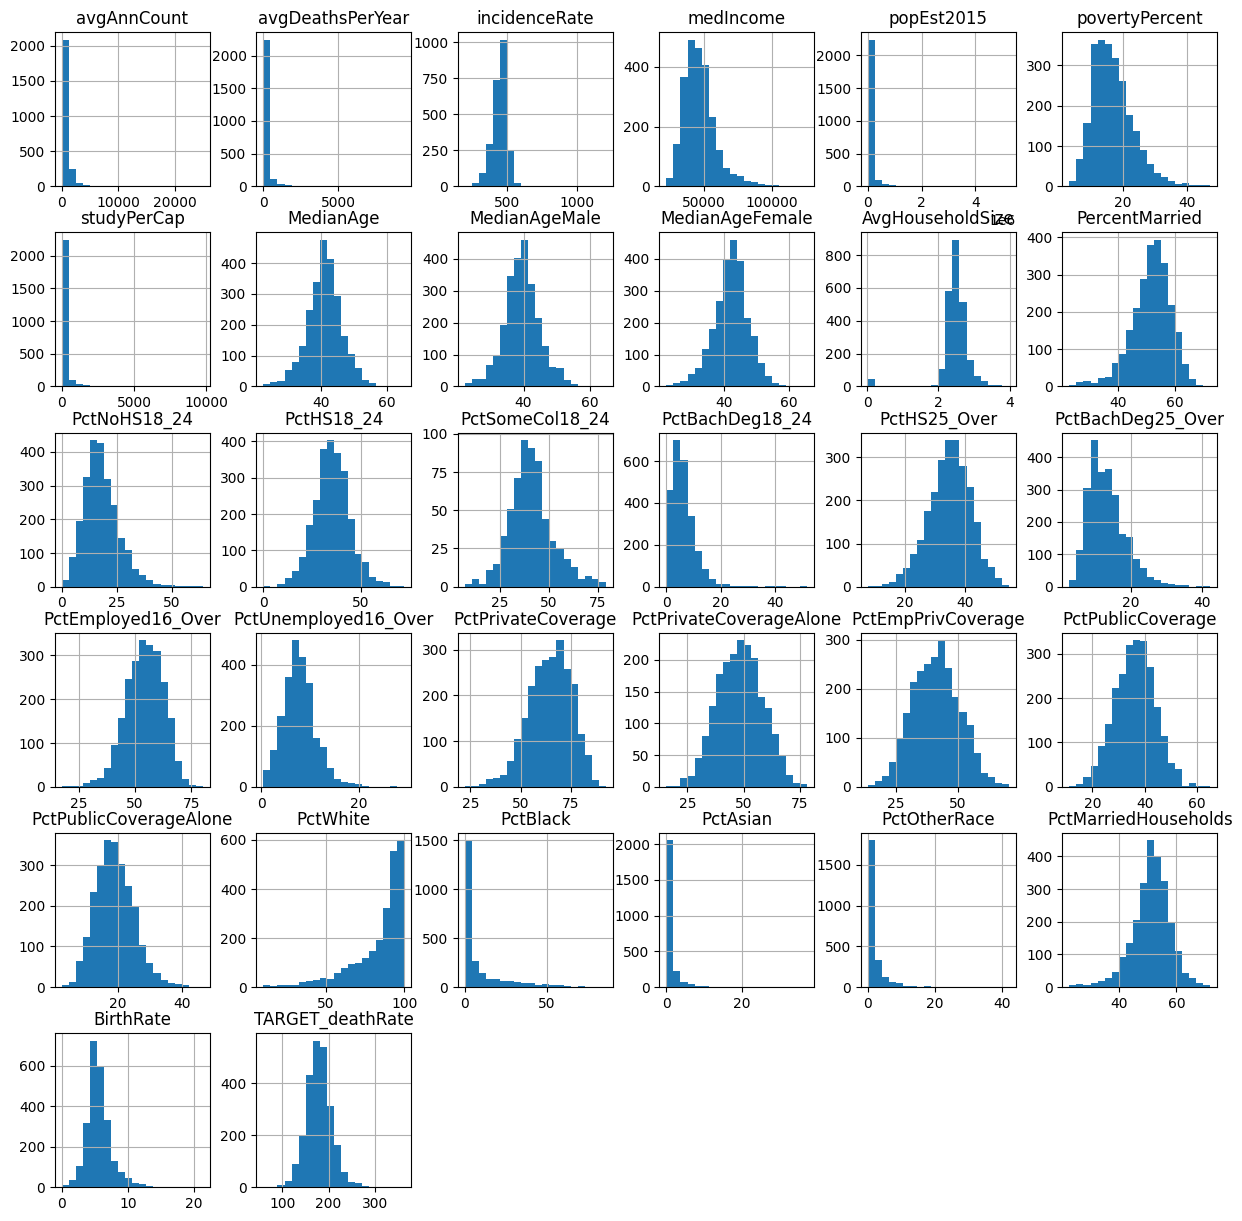

Top five features with strongest correlations to the target:
incidenceRate             0.443983
PctPublicCoverageAlone    0.439734
povertyPercent            0.413260
PctHS25_Over              0.409915
PctPublicCoverage         0.391899
Name: TARGET_deathRate, dtype: float64


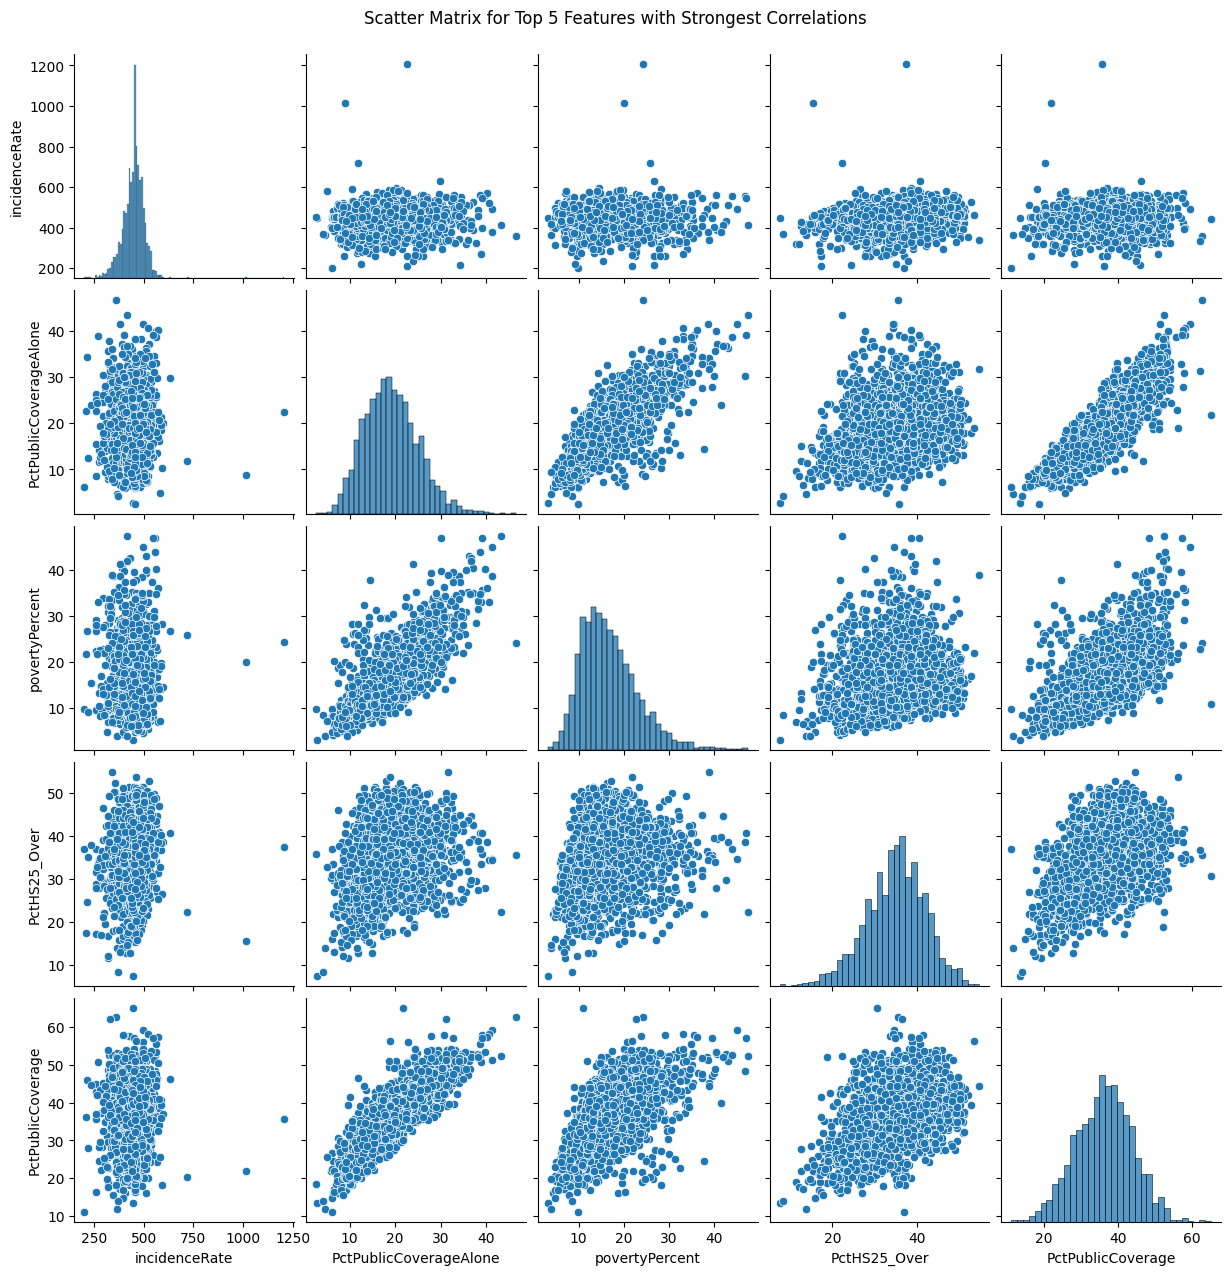

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read training data
training_data = pd.read_csv(training_data_path)
training_targets = pd.read_csv(training_targets_path)

# Concatenate data and targets for the analysis
full_data = pd.concat([training_data, training_targets], axis=1)

# Correct outliers in MedianAge
median_age_outliers = full_data[full_data['MedianAge'] > 100]
median_age_mean = full_data['MedianAge'].mean()
full_data['MedianAge'] = full_data['MedianAge'].apply(lambda x: median_age_mean if x > 100 else x)

# Plot histograms of all features
full_data.hist(bins=20, figsize=(15, 15))
plt.show()

# Display top 5 correlations with the target variable
correlations = full_data.corr()['TARGET_deathRate'].sort_values(ascending=False)
top_features = correlations.head(6)[1:]
print("Top five features with strongest correlations to the target:")
print(top_features)

# Plot scatter matrix for the top five features
sns.pairplot(full_data, vars=top_features.index)
plt.suptitle('Scatter Matrix for Top 5 Features with Strongest Correlations', y=1.02)
plt.show()



Regarding any unsual values, we can look for plots that deviate from normal distribution. There does not seem to be any oulier data other than the median age features.

Based on the scatter matrix plots:

We can see positive correlation between PctPrivateCoverage and PctPrivateCoverageAlone. This makes sense as individuals with private health coverage alone contribute to the overall percentage of individuals with private health coverage. The positive correlation indicates that as one of these percentages increases, the other increases as well.

Negative Correlation can be seen in povertyPercent vs. medianIncome. This negative correlation is also expected as higher poverty percentages are associated with lower median incomes. Counties with higher poverty percentages will tend to have lower median incomes, and vice versa.

**Next step**

Create an ML pipeline using scikit-learn to pre-process the training data.

To prepare the data for modeling, I use the `sklearn` library, specifically components like `SimpleImputer`, `StandardScaler`, `OneHotEncoder`, and `Pipeline`, along with a custom `DataFrameSelector`.
This setup allows for efficient preprocessing of both numerical and categorical data. The `DataFrameSelector` is also useful, as it enables the creation of two parallel pipelines—one for numerical and another for categorical features—streamlining the process.

- Numerical data is handled through a pipeline that includes median imputation and standard scaling to normalize the data, ensuring that our model isn't biased by the scale of the measurements.

- Categorical data, on the other hand, is processed through a pipeline that applies one-hot encoding, which converts categorical variable values into a form that could be provided to ML algorithms to do a better job in prediction.

By combining these pipelines using a `ColumnTransformer`, I can ensure that each feature is appropriately preprocessed before being used in any model training. This comprehensive preparation culminates in applying the full pipeline to both the training and testing datasets, transforming them into forms suitable for machine learning tasks. Lastly, I display the original and transformed data, illustrating the  transformation of the dataset for modeling.

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# Load the training data and targets
data = pd.read_csv('Training_data.csv')
targets = pd.read_csv('Training_data_targets.csv')

# Separate features and target
X = data
y = targets['TARGET_deathRate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The DataFrameSelector to create two parallel pipelines 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

# Separate numerical and categorical features
numerical_features = data.select_dtypes(include=['number']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Create pipelines for numerical features
numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical_features)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

# and categorical features
categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_features)),
    ('one_hot_encoder', OneHotEncoder())
])

# Combine the pipelines using ColumnTransformer
full_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Fit and transform the data with the full pipeline on the training set
transformed_data_train = full_pipeline.fit_transform(X_train)

# Transform the test set using the full pipeline
transformed_data_test = full_pipeline.transform(X_test)

# Display the original and transformed data (optional)
print("Original Data:")
print(data.head())

print("\nTransformed Data:")
print(pd.DataFrame(transformed_data_train).head())


Original Data:
   avgAnnCount  avgDeathsPerYear  incidenceRate  medIncome  popEst2015  \
0         59.0                30          404.3      33975        8251   
1        114.0                41          403.8      47363       22702   
2         33.0                11          352.0      77222        9899   
3        254.0               100          429.6      80650       48904   
4         75.0                32          407.5      42839       22255   

   povertyPercent  studyPerCap  MedianAge  MedianAgeMale  MedianAgeFemale  \
0            20.5          0.0       51.3           50.8             51.9   
1            13.8          0.0       40.8           39.8             42.7   
2             6.8          0.0       38.1           36.9             39.8   
3             7.5          0.0       43.5           42.7             44.1   
4            14.6          0.0       31.1           30.2             31.6   

   ...  PctPrivateCoverageAlone  PctEmpPrivCoverage  PctPublicCoverage  \
0  

**Regression**

Using `LinearRegression`, `Lasso`, and `Ridge`, I can address the dataset that we've already preprocessed.

Beginning with Ordinary Least Squares (OLS) regression, employing `LinearRegression`. By calculating the Mean Squared Error (MSE) through cross-validation, we can get a robust estimate of the model's performance. This step is crucial as it gives us a baseline to compare other models.

Next, we focus on Lasso Regression, known for its ability to perform variable selection and regularization to enhance the prediction accuracy. We use `GridSearchCV` to find the optimal regularization strength, referred to as alpha. This process ensures that we are using the best parameter, enhancing Lasso's ability to identify the most relevant features and potentially improving model accuracy.

After determining the best alpha, we fit a new Lasso model using this value and make predictions on our test set. The resulting MSE from these predictions provides a quantitative measure of Lasso's performance, giving further insight into how well it generalizes to new data.

Then applying a similar approach with Ridge Regression, another method that uses regularization to reduce model complexity and prevent overfitting. Again, `GridSearchCV` helps find the optimal alpha value. By fitting the Ridge model with this alpha and making predictions, we calculate the MSE, allowing us to assess and compare its performance directly against the OLS and Lasso models.


Finally, compiling the results from all three models—OLS, Lasso, and Ridge—and to determine which model performs best based on the lowest MSE. This comparative analysis is most informative as to which regression technique is most effective for the dataset.

In [10]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Ordinary Least Squares (OLS)
ols_reg = LinearRegression()
ols_mse = -cross_val_score(ols_reg, transformed_data_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()

# Lasso Regression
lasso_reg = Lasso()

# Perform GridSearchCV to find the best alpha value
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso_reg, lasso_params, scoring = 'neg_mean_squared_error', cv = 5)
lasso_grid.fit(transformed_data_train, y_train)
lasso_best_alpha = lasso_grid.best_params_['alpha']

# Create a new Lasso model with the best alpha and fit it
lasso_reg = Lasso(alpha=lasso_best_alpha)
lasso_reg.fit(transformed_data_train, y_train)

# Make predictions and calculate mse
lasso_predictions = lasso_reg.predict(transformed_data_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)


# Ridge Regression
ridge_reg = Ridge()

# Perform GridSearchCV to find the best alpha value
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_reg, ridge_params, scoring = 'neg_mean_squared_error', cv = 5)
ridge_grid.fit(transformed_data_train, y_train)
ridge_best_alpha = ridge_grid.best_params_['alpha']

# Create a new Ridge model with the best alpha
ridge_reg = Ridge(alpha=ridge_best_alpha)
ridge_reg.fit(transformed_data_train, y_train)

# Make predictions and calculate mse
ridge_predictions = ridge_reg.predict(transformed_data_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)


# Compare results
results = {
    'OLS': ols_mse,
    'Lasso': lasso_mse,
    'Ridge': ridge_mse
}

best_model = min(results, key=results.get)
best_mse = results[best_model]

# Display results
print("Cross-Validated Mean Squared Error (MSE) for OLS: {:.4f}".format(ols_mse))
print("Cross-Validated Mean Squared Error (MSE) for Lasso: {:.4f} (Best alpha: {})".format(lasso_mse, lasso_best_alpha))
print("Cross-Validated Mean Squared Error (MSE) for Ridge: {:.4f} (Best alpha: {})".format(ridge_mse, ridge_best_alpha))

print("\nBest Performing Model: {}".format(best_model))
print("Cross-Validated MSE of the Best Performing Model: {:.4f}".format(best_mse))


Cross-Validated Mean Squared Error (MSE) for OLS: 386.8304
Cross-Validated Mean Squared Error (MSE) for Lasso: 352.6522 (Best alpha: 0.1)
Cross-Validated Mean Squared Error (MSE) for Ridge: 349.9903 (Best alpha: 10)

Best Performing Model: Ridge
Cross-Validated MSE of the Best Performing Model: 349.9903


In this analysis, the three linear regression models: Ordinary Least Squares (OLS), Lasso, and Ridge—were fitted to thr already pre processed data. The regularization weights for Lasso and Ridge were determined through hyperparameter tuning with GridSearchCV. For Lasso and Ridge models, a range of alpha values (0.01, 0.1, 1, 10, 100) was used to identify the most ideal value based on a cross-validated mean squared error. The identified optimal alpha values were then utilized to create new Lasso and Ridge models. Cross-validation using the negative mean squared error as the scoring metric was used to quantitatively compare the performance of theses models.

The best-performing model was determined by the lowest Cross-Validated MSE and was Ridge regression. Specifically, the Ridge model with an alpha value of 10 showed the most favorable performance and achieved a Cross-Validated MSE of 349.9903. This outcome highlights the effectiveness of the Ridge model in predictive accuracy. The provided code outlines with comments the entire process, from model fitting and hyperparameter tuning to the quantitative comparison of results.